## 1 房价预测

In [64]:
%matplotlib inline

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import my_utils

torch.set_default_tensor_type(torch.FloatTensor)

### 1.1 导入数据集并观察

In [65]:
train_data = pd.read_csv('../data/kaggle_house/train.csv')
test_data = pd.read_csv('../data/kaggle_house/test.csv')
print(train_data.shape, test_data.shape)    # 最后一列为label，test data中这是我们需要预测的变量
train_data.iloc[0:4, :]

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


第一个特征id显然不应当作为feature：

In [66]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 1.2 数据预处理
首先，对连续数值型的特征做标准化：
$$
x \leftarrow \frac{x - \overline{x}}{\sigma},
$$
对于确实的特征（NaN），将其设为均值。

In [67]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# numeric_features存储了数据型特征的index，对每个特征依次采取标准化操作
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

其次，将离散特征转换为指示特征。以MSZoning为例，包含RL和RM两个取值。去掉这一列并添加MSZoning_RL和MSZoning_RM，取值为0或1。

In [68]:
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

(2919, 331)


最后，将特征和标签转为numpy格式的数据。

In [69]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)
print(train_features.shape, test_features.shape, '\n', train_labels)

torch.Size([1460, 331]) torch.Size([1459, 331]) 
 tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])


### 1.3 定义模型训练过程
使用线性模型和均方误差。

In [70]:
loss = nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

定义对数均方误差（而非准确率等等常用的分类问题的评估方法）用于评估模型（这是比赛的要求，因此不应当被track梯度）：
$$
l = \sqrt{\frac{1}{n} \sum_{i=1}^n \big( \log(y_i) - \log(\hat{y}_i) \big)^2}
$$

In [71]:
def log_rmse(net, features, labels):
    # with语句保证下面的计算不会track网络的参数的梯度
    with torch.no_grad():
        # 将小于1的预测结果设为1，从而保证取对数数值不会坍缩
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

定义模型训练过程：

In [72]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        # 测试集是我们根据K折交叉验证在训练集上构造出来的
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### 1.4 定义K折交叉验证
将训练集划分为K个不重合的子数据集，做K次模型的训练和验证。每一次采用一个子数据集做验证，剩下的K-1个子数据集训练。

In [73]:
def get_k_fold_data(k, i, X, y):
    """
    获取第i折交叉验证时的训练和验证数据。
    第i折的子数据集为验证集，其余为训练集。
    """
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

定义K轮交叉验证的训练过程，返回训练和验证的平均（对数）误差：

In [74]:
def k_fold_train(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size):
    train_ls_sum, valid_ls_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        train_ls_sum += train_ls[-1]
        valid_ls_sum += valid_ls[-1]
        if i == 0:
            my_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse', 
                              range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        # 输出每次交叉训练中最后一个epoch的训练和验证结果
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_ls_sum / k, valid_ls_sum / k

### 1.5 训练模型

fold 0, train rmse 0.137038, valid rmse 0.143954
fold 1, train rmse 0.134248, valid rmse 0.149219
fold 2, train rmse 0.132691, valid rmse 0.142299
fold 3, train rmse 0.137593, valid rmse 0.139039
fold 4, train rmse 0.130414, valid rmse 0.169038
5-fold validation: avg train rmse 0.134397, avg valid rmse 0.148710


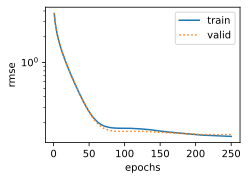

In [80]:
k, num_epochs, lr, weight_decay, batch_size = 5, 250, 5, 0, 64
train_l, valid_l = k_fold_train(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

### 1.6 训练、预测并生成相应的提交文件

In [85]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    my_utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('../data/kaggle_house/submission.csv', index=False)

train rmse 0.130912


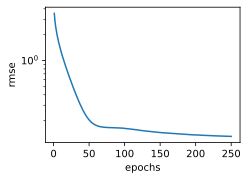

In [86]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

可以将超参数的取值用切片的方式列出来，依次带入训练，找到最好的一组超参数。